In [57]:
import sqlalchemy as sa
import pandas as pd

import logging
import requests

from sqlalchemy.sql import text

In [59]:
ENVIRONMENT = "production"

In [60]:
if ENVIRONMENT == 'production':
    url = 'https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json'
    params = requests.get(url).json()['params']

    engine = sa.create_engine('postgresql+psycopg2://' + params['user'] \
                            + ':' + params['password'] + '@' + params['host'] \
                            + '/' + params['dbname'])
    engine.begin()

elif ENVIRONMENT == 'staging':
    params = {
        "dbname" : "alercedb",
        "user" : "reader",
        "host": "44.210.122.226",
        "password" : "8QvBS4aG4e49N5MX3ddSWpAH",
        "port": 5432
    }

    engine = sa.create_engine(
        f"postgresql://{params['user']}:{params['password']}@{params['host']}:{params['port']}/{params['dbname']}"
        )
    engine.begin()

else:
    raise ValueError(f'{ENVIRONMENT} not defined')

In [61]:
from sqlalchemy import inspect

inspector = inspect(engine)
tables = inspector.get_table_names()
print(tables)

['outlier', 'feature_version', 'gaia_ztf', 'alembic_version', 'ss_ztf', 'allwise', 'non_detection', 'step', 'taxonomy', 'feature', 'pipeline', 'lc_classifier_top', 'lc_classifier_periodic', 'lc_classifier_transient', 'magstat', 'lc_classifier', 'stamp_classifier', 'dataquality', 'object', 'lc_classifier_stochastic', 'lc_classifier_beta', 'forced_photometry', 'lc_classifier_bhrf_forced_phot_childs', 'reference', 'ps1_ztf', 'xmatch', 'detection', 'probability']


In [62]:
inspector = inspect(engine)
columns = inspector.get_columns("object")

for column in columns:
    print(column["name"], column["type"])

oid VARCHAR
ndethist INTEGER
ncovhist INTEGER
mjdstarthist DOUBLE PRECISION
mjdendhist DOUBLE PRECISION
corrected BOOLEAN
stellar BOOLEAN
ndet INTEGER
g_r_max REAL
g_r_max_corr REAL
g_r_mean REAL
g_r_mean_corr REAL
meanra DOUBLE PRECISION
meandec DOUBLE PRECISION
sigmara DOUBLE PRECISION
sigmadec DOUBLE PRECISION
deltajd DOUBLE PRECISION
firstmjd DOUBLE PRECISION
lastmjd DOUBLE PRECISION
step_id_corr VARCHAR
diffpos BOOLEAN
reference_change BOOLEAN


In [65]:
from astropy.time import Time

mjd = Time("2025-03-18").mjd
mjd

np.float64(60752.0)

In [66]:
# Construimos la consulta SQL
query = f"""
    SELECT * FROM object 
    WHERE lastmjd >= {mjd};
"""

# Ejecutamos la consulta
objects = pd.read_sql_query(query, con=engine)

display(objects.head())
print(objects.shape)
print(objects.columns)

OperationalError: (psycopg2.errors.QueryCanceled) canceling statement due to statement timeout

[SQL: 
    SELECT * FROM object 
    WHERE lastmjd >= 60752.0;
]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [56]:
oids = list(objects.oid.values[:10])
print(f'Num. oids: {len(oids)}')

oids = [f"'{oid}'" for oid in oids]
query_detections = f"""
    SELECT * FROM detection
    WHERE oid IN ({','.join(oids)}) and rb >= 0.55;
"""

detections = pd.read_sql_query(query_detections, con=engine)
oids_mayor_8 = detections['oid'].value_counts()
oids = oids_mayor_8[oids_mayor_8 >= 8].index
print(f'Num. oids ndet >= 8: {len(oids)}')

oids = [f"'{oid}'" for oid in oids]
print(oids)

Num. oids: 10


OperationalError: (psycopg2.OperationalError) could not receive data from server: Connection timed out
SSL SYSCALL error: Connection timed out

[SQL: 
    SELECT * FROM detection
    WHERE oid IN ('ZTF18acbvugl','ZTF18aaaasok','ZTF23aahpjql','ZTF18aaawoqz','ZTF18acruvya','ZTF18acbvugo','ZTF18abeskdh','ZTF18ablwchy','ZTF19aafotnh','ZTF19aapjufp') and rb >= 0.55;
]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [54]:
query_detections = f"""
    SELECT * FROM detection
    WHERE oid IN ({','.join(oids)}) and rb >= 0.55;
"""

detections = pd.read_sql_query(query_detections, con=engine)
display(detections.head())
print(detections.shape)
print(detections.columns)

,candid,oid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,...,sigmagapbig,rfid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious,parent_candid,has_stamp,step_id_corr
0,2973215775215010006,ZTF18acbvugo,60727.215776,2,2.973216e+12,20.258900,-1,2973,89.515331,65.451140,...,0.0628,NaN,16.363913,0.012502,0.021529,True,False,2.997260e+18,False,27.4.1a4
1,2971194615215015015,ZTF18acbvugo,60725.194618,1,2.971195e+12,20.225800,1,2971,89.515233,65.451098,...,0.1110,NaN,16.795903,0.016026,0.022216,True,False,2.997260e+18,False,27.4.1a4
2,2971139535215015005,ZTF18acbvugo,60725.139537,2,2.971140e+12,19.517500,1,2971,89.515246,65.451075,...,0.1347,NaN,15.951634,0.017754,0.021423,True,False,2.997260e+18,False,27.4.1a4
3,2969161215215010001,ZTF18acbvugo,60723.161215,1,2.969161e+12,20.155399,-1,2969,89.515365,65.451138,...,0.2447,NaN,17.247394,0.040123,0.046407,True,False,2.997260e+18,False,27.4.1a4
4,2997260235215015005,ZTF18acbvugo,60751.260232,2,2.997260e+12,19.688288,1,2997,89.515207,65.451085,...,0.1504,812120252.0,15.963213,0.007753,0.014385,True,False,NaN,True,27.4.1a4


(9, 30)
Index(['candid', 'oid', 'mjd', 'fid', 'pid', 'diffmaglim', 'isdiffpos', 'nid',
       'ra', 'dec', 'magpsf', 'sigmapsf', 'magap', 'sigmagap', 'distnr', 'rb',
       'rbversion', 'drb', 'drbversion', 'magapbig', 'sigmagapbig', 'rfid',
       'magpsf_corr', 'sigmapsf_corr', 'sigmapsf_corr_ext', 'corrected',
       'dubious', 'parent_candid', 'has_stamp', 'step_id_corr'],
      dtype='object')


In [55]:
detections

,candid,oid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,...,sigmagapbig,rfid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious,parent_candid,has_stamp,step_id_corr
0,2973215775215010006,ZTF18acbvugo,60727.215776,2,2.973216e+12,20.258900,-1,2973,89.515331,65.451140,...,0.0628,NaN,16.363913,0.012502,0.021529,True,False,2.997260e+18,False,27.4.1a4
1,2971194615215015015,ZTF18acbvugo,60725.194618,1,2.971195e+12,20.225800,1,2971,89.515233,65.451098,...,0.1110,NaN,16.795903,0.016026,0.022216,True,False,2.997260e+18,False,27.4.1a4
2,2971139535215015005,ZTF18acbvugo,60725.139537,2,2.971140e+12,19.517500,1,2971,89.515246,65.451075,...,0.1347,NaN,15.951634,0.017754,0.021423,True,False,2.997260e+18,False,27.4.1a4
3,2969161215215010001,ZTF18acbvugo,60723.161215,1,2.969161e+12,20.155399,-1,2969,89.515365,65.451138,...,0.2447,NaN,17.247394,0.040123,0.046407,True,False,2.997260e+18,False,27.4.1a4
4,2997260235215015005,ZTF18acbvugo,60751.260232,2,2.997260e+12,19.688288,1,2997,89.515207,65.451085,...,0.1504,812120252.0,15.963213,0.007753,0.014385,True,False,NaN,True,27.4.1a4
5,2997196485215015008,ZTF18acbvugo,60751.196481,1,2.997196e+12,20.246693,1,2997,89.515161,65.451074,...,0.1244,812120152.0,16.822170,0.018885,0.024598,True,False,NaN,True,27.4.1a4
6,2960386155215015101,ZTF18acbvugo,60714.386157,1,2.960386e+12,18.839701,1,2960,89.515074,65.451081,...,0.3864,NaN,16.824123,0.036979,0.040209,True,False,2.979287e+18,False,27.4.1a3
7,2952274895215010005,ZTF18acbvugo,60706.274896,2,2.952275e+12,20.403400,-1,2952,89.515355,65.451111,...,0.0819,NaN,16.308656,0.009758,0.019304,True,False,2.979287e+18,False,27.4.1a3
8,2979286675215010001,ZTF18acbvugo,60733.286678,1,2.979287e+12,19.913897,-1,2979,89.515464,65.451136,...,0.1866,812120152.0,17.274984,0.016883,0.029277,True,False,NaN,True,27.4.1a3


In [ ]:
# FORCED PHOTOMETRY
query_forced_photometry = f"""
                    SELECT * FROM forced_photometry
                    WHERE oid in ({','.join(oids)}) and procstatus in ('0', '57');
                    """

forced_photometry = pd.read_sql_query(query_forced_photometry, con=engine)
display(forced_photometry.head())
print(forced_photometry.shape)
print(forced_photometry.columns)

,pid,oid,mjd,fid,ra,dec,e_ra,e_dec,mag,e_mag,...,diffmaglim,programid,procstatus,distnr,ranr,decnr,magnr,sigmagnr,chinr,sharpnr
0,2990276585215,ZTF18acbvugo,60744.276586,2,89.515207,65.451085,None,None,18.680624,0.071297,...,19.4405,1,0,0.199096,89.515289,65.451126,16.120001,0.014,0.415,-0.026
1,2985130265215,ZTF18acbvugo,60739.130266,1,89.515207,65.451085,None,None,19.603615,0.125897,...,19.8738,1,0,0.206073,89.515305,65.451126,17.025000,0.019,0.889,-0.053
2,2979286675215,ZTF18acbvugo,60733.286678,1,89.515207,65.451085,None,None,18.782604,0.052794,...,19.9139,1,0,0.206073,89.515305,65.451126,17.025000,0.019,0.889,-0.053
3,2977200245215,ZTF18acbvugo,60731.200243,2,89.515207,65.451085,None,None,19.534048,0.085465,...,20.0529,1,0,0.199096,89.515289,65.451126,16.120001,0.014,0.415,-0.026
4,2977139185215,ZTF18acbvugo,60731.139190,1,89.515207,65.451085,None,None,19.351608,0.058809,...,20.5478,1,0,0.206073,89.515305,65.451126,17.025000,0.019,0.889,-0.053


(8, 42)
Index(['pid', 'oid', 'mjd', 'fid', 'ra', 'dec', 'e_ra', 'e_dec', 'mag',
       'e_mag', 'mag_corr', 'e_mag_corr', 'e_mag_corr_ext', 'isdiffpos',
       'corrected', 'dubious', 'parent_candid', 'has_stamp', 'field', 'rcid',
       'rfid', 'sciinpseeing', 'scibckgnd', 'scisigpix', 'magzpsci',
       'magzpsciunc', 'magzpscirms', 'clrcoeff', 'clrcounc', 'exptime',
       'adpctdif1', 'adpctdif2', 'diffmaglim', 'programid', 'procstatus',
       'distnr', 'ranr', 'decnr', 'magnr', 'sigmagnr', 'chinr', 'sharpnr'],
      dtype='object')


In [32]:
forced_photometry

,pid,oid,mjd,fid,ra,dec,e_ra,e_dec,mag,e_mag,...,diffmaglim,programid,procstatus,distnr,ranr,decnr,magnr,sigmagnr,chinr,sharpnr
0,2990276585215,ZTF18acbvugo,60744.276586,2,89.515207,65.451085,None,None,18.680624,0.071297,...,19.440500,1,0,0.199096,89.515289,65.451126,16.120001,0.014,0.415,-0.026
1,2985130265215,ZTF18acbvugo,60739.130266,1,89.515207,65.451085,None,None,19.603615,0.125897,...,19.873800,1,0,0.206073,89.515305,65.451126,17.025000,0.019,0.889,-0.053
2,2979286675215,ZTF18acbvugo,60733.286678,1,89.515207,65.451085,None,None,18.782604,0.052794,...,19.913900,1,0,0.206073,89.515305,65.451126,17.025000,0.019,0.889,-0.053
3,2977200245215,ZTF18acbvugo,60731.200243,2,89.515207,65.451085,None,None,19.534048,0.085465,...,20.052900,1,0,0.199096,89.515289,65.451126,16.120001,0.014,0.415,-0.026
4,2977139185215,ZTF18acbvugo,60731.139190,1,89.515207,65.451085,None,None,19.351608,0.058809,...,20.547800,1,0,0.206073,89.515305,65.451126,17.025000,0.019,0.889,-0.053
5,2975197735215,ZTF18acbvugo,60729.197732,1,89.515207,65.451085,None,None,20.370497,0.190034,...,20.180401,1,0,0.206073,89.515305,65.451126,17.025000,0.019,0.889,-0.053
6,2975166605215,ZTF18acbvugo,60729.166609,2,89.515207,65.451085,None,None,20.378475,0.194864,...,20.111099,1,0,0.199096,89.515289,65.451126,16.120001,0.014,0.415,-0.026
7,2997196485215,ZTF18acbvugo,60751.196481,1,89.515207,65.451085,None,None,18.696323,0.042672,...,20.246700,1,0,0.206073,89.515305,65.451126,17.025000,0.019,0.889,-0.053


In [33]:
# GET FEATURES
query_features = f"""
                SELECT * FROM feature as f 
                WHERE f.oid in ({','.join(oids)}) and f.version = '27.4.1a4';
                """

features = pd.read_sql_query(query_features, con=engine)
features

,oid,name,value,fid,version
0,ZTF18acbvugo,Amplitude,NaN,1,27.4.1a4
1,ZTF18acbvugo,Amplitude,NaN,2,27.4.1a4
2,ZTF18acbvugo,AndersonDarling,NaN,1,27.4.1a4
3,ZTF18acbvugo,AndersonDarling,NaN,2,27.4.1a4
4,ZTF18acbvugo,Autocor_length,NaN,1,27.4.1a4
...,...,...,...,...,...
204,ZTF18acbvugo,ulens_t0,2.396655e+01,2,27.4.1a4
205,ZTF18acbvugo,ulens_tE,1.121472e+01,1,27.4.1a4
206,ZTF18acbvugo,ulens_tE,5.473820e-01,2,27.4.1a4
207,ZTF18acbvugo,ulens_u0,1.526989e+02,1,27.4.1a4


In [34]:
def features_from_db(features: pd.DataFrame):
    def normalize_name(x: str | int):
        if "_0" in x:
            return x[:-2].replace("/", "_")
        return x.replace("/", "_")

    def normalize_fid(x):
        if x == 0:
            return None
        if x == 1:
            return "g"
        if x == 2:
            return "r"
        if x == 12:
            return "g,r"

    # features['name'] = features['name'] + '_' + features['fid'].astype(str)
    if len(features) >= 1:
        features["name"] = features.apply(lambda x: normalize_name(x["name"]), axis=1)
        features["fid"] = features.apply(lambda x: normalize_fid(x["fid"]), axis=1)
        return features
    else:
        return None

In [35]:
#features = features_from_db(features)
#features

In [36]:
data_dict = {
    "detections": detections,
    "forced_photometry": forced_photometry,
    "features": features,
    "xmatch": None,
    "reference": None,
}

In [37]:
import numpy as np

mag_corr_column = "magpsf_corr"
e_mag_corr_ext_column = "sigmapsf_corr_ext"
diff_mag_column = "magpsf"
e_diff_mag_column = "sigmapsf"
mag_corr_column_fp = "mag_corr"
e_mag_corr_ext_column_fp = "e_mag_corr_ext"
diff_mag_column_fp = "mag"
e_diff_mag_column_fp = "e_mag"
w1_column = "w1mpro"
w2_column = "w2mpro"
w3_column = "w3mpro"
w4_column = "w4mpro"


detection_keys = [
    "oid",
    "candid",
    "pid",
    "ra",
    "dec",
    "mjd",
    mag_corr_column,
    e_mag_corr_ext_column,
    diff_mag_column,
    e_diff_mag_column,
    "fid",
    "isdiffpos",
]

forced_photometry_keys = [
    "oid",
    "candid",
    "pid",
    "ra",
    "dec",
    "mjd",
    mag_corr_column_fp,
    e_mag_corr_ext_column_fp,
    diff_mag_column_fp,
    e_diff_mag_column_fp,
    "fid",
    "isdiffpos",
]

def mag2flux(mag):
    return 10 ** (-(mag - 23.9) / 2.5)

def mag_err_2_flux_err(mag_err, mag):
    return np.log(10.0) * mag2flux(mag) / 2.5 * mag_err

def recover_mag_and_emag_with_signed_flux(df):
    df["isdiffpos"] = np.sign(df["fluxdiff_uJy"]).astype(int)
    df["mag"] = -2.5 * np.log10(np.abs(df["fluxdiff_uJy"])) + 23.9
    df["e_mag"] = df["fluxerrdiff_uJy"] / np.abs(df["fluxdiff_uJy"])
    df.loc[df["fluxdiff_uJy"] == 0, ["mag", "e_mag"]] = np.nan
    return df

def get_det_AO_to_InputDTO(lightcurve):
    detections = lightcurve.copy()
    detections = detections[detections.unit == "diff_flux"].rename(
        columns={
            "brightness": "fluxdiff_uJy",
            "e_brightness": "fluxerrdiff_uJy",
        }
    )
    detections = recover_mag_and_emag_with_signed_flux(detections)
    return detections

def preprocess_detections_from_db(detections: pd.DataFrame) -> pd.DataFrame:

    detections_ = detections.copy()
    detections_.fillna(value=np.nan, inplace=True)
    detections_["forced"] = False
    detections_["unit"] = "diff_flux"

    detections_.rename(
        columns={
            mag_corr_column: "mag_corr",
            e_mag_corr_ext_column: "e_mag_corr_ext", # sigmapsf_corr_ext
            diff_mag_column: "mag",
            e_diff_mag_column: "e_mag",
        },
        inplace=True,
    )

    detections_.rename(
        columns={"mag_corr": "brightness", "e_mag_corr_ext": "e_brightness"},
        inplace=True,
    )

    detections_["brightness"] = mag2flux(detections_["mag"]) * detections_["isdiffpos"]
    detections_["e_brightness"] = mag_err_2_flux_err(
        detections_["e_mag"], detections_["mag"]
    )
    return detections_

def preprocess_forced_photometry_from_db(
    forced_photometry: pd.DataFrame,
) -> pd.DataFrame:

    forced_photometry_ = forced_photometry.copy()
    forced_photometry_.fillna(value=np.nan, inplace=True)
    forced_photometry_["unit"] = "diff_flux"
    forced_photometry_.rename(
        columns={
            mag_corr_column_fp: "mag_corr",
            e_mag_corr_ext_column_fp: "e_mag_corr_ext",
            diff_mag_column_fp: "mag",
            e_diff_mag_column_fp: "e_mag",
        },
        inplace=True,
    )

    forced_photometry_.rename(
        columns={"mag_corr": "brightness", "e_mag_corr_ext": "e_brightness"},
        inplace=True,
    )

    forced_photometry_["brightness"] = (
        mag2flux(forced_photometry_["mag"]) * forced_photometry_["isdiffpos"]
    )
    forced_photometry_["e_brightness"] = mag_err_2_flux_err(
        forced_photometry_["e_mag"], forced_photometry_["mag"]
    )

    forced_photometry_["candid"] = forced_photometry_["oid"].astype(str) + forced_photometry_["pid"].astype(str) 

    return forced_photometry_

def preprocess_detections_and_forced_photometry_from_db(
    detections: pd.DataFrame, forced_photometry: pd.DataFrame
) -> pd.DataFrame:
    columns = ['oid', 'mjd']
    print(f'detections:\n{detections[columns]}') 
    print(f'forced_photometry:\n{forced_photometry[columns]}') 

    detections_and_forced_photometry = pd.concat(
        [
            preprocess_detections_from_db(detections),
            preprocess_forced_photometry_from_db(forced_photometry),
        ]
    )

    detections_and_forced_photometry = get_det_AO_to_InputDTO(detections_and_forced_photometry)
    print(f'1. detections_and_forced_photometry:\n{detections_and_forced_photometry[columns]}') 
    detections_and_forced_photometry.drop_duplicates(["candid", "oid"], inplace=True)
    print(f'2. detections_and_forced_photometry:\n{detections_and_forced_photometry[columns]}')
    detections_and_forced_photometry.sort_values(
        by=["mjd", "forced"], ascending=[True, False], inplace=True
    )
    print(f'3. detections_and_forced_photometry:\n{detections_and_forced_photometry[columns]}')
    detections_and_forced_photometry.set_index("oid", inplace=True)
    return detections_and_forced_photometry

In [38]:
def preprocess_features_from_db(features: pd.DataFrame) -> pd.DataFrame:
    """features come from db in column format"""
    def fid_map(v):
        if v == 1:
            return "_1"  #'g'
        if v == 2:
            return "_2"  #'r'
        if v == 0:
            return ""
        
        if v == 12:
            return "_12"

    def normalize_name(v):
        return str(v).replace("-", "_").replace('/', '_')

    features_ = features.copy()
    features_["fid_name"] = features_["fid"].apply(lambda x: fid_map(x))
    features_["name"] = features_["name"] + features_["fid_name"]
    features_["name"] = features_["name"].apply(lambda x: normalize_name(x))
    features_ = features_[["oid", "name", "value"]]
    features_ = features_.pivot_table(
        index="oid", columns="name", values="value", aggfunc="first", dropna=False
    )

    return features_

In [39]:
from alerce_classifiers.base.dto import InputDTO
from alerce_classifiers.base._types import *

def transform_dataframes_to_input_dto(data: dict) -> InputDTO:
    """get dataframes from detections and forced photometry"""

    detections_and_forced_photometry = (
        preprocess_detections_and_forced_photometry_from_db(
            data["detections"], data["forced_photometry"]
        )
    )

    features = preprocess_features_from_db(data["features"])
    """ format dataframe of features """

    return InputDTO(
        Detections(detections_and_forced_photometry),
        NonDetections(pd.DataFrame()),
        Features(pd.DataFrame(features)),
        Xmatch(pd.DataFrame()),
        Stamps(pd.DataFrame()),
    )

In [40]:
inspector = inspect(engine)
columns = inspector.get_columns("object")

for column in columns:
    print(column["name"], column["type"])

oid VARCHAR
ndethist INTEGER
ncovhist INTEGER
mjdstarthist DOUBLE PRECISION
mjdendhist DOUBLE PRECISION
corrected BOOLEAN
stellar BOOLEAN
ndet INTEGER
g_r_max DOUBLE PRECISION
g_r_max_corr DOUBLE PRECISION
g_r_mean DOUBLE PRECISION
g_r_mean_corr DOUBLE PRECISION
meanra DOUBLE PRECISION
meandec DOUBLE PRECISION
sigmara DOUBLE PRECISION
sigmadec DOUBLE PRECISION
deltajd DOUBLE PRECISION
firstmjd DOUBLE PRECISION
lastmjd DOUBLE PRECISION
step_id_corr VARCHAR
diffpos BOOLEAN
reference_change BOOLEAN


In [41]:
input_dto = transform_dataframes_to_input_dto(data_dict)
input_dto

detections:
            oid           mjd
0  ZTF18acbvugo  60727.215776
1  ZTF18acbvugo  60725.194618
2  ZTF18acbvugo  60725.139537
3  ZTF18acbvugo  60723.161215
4  ZTF18acbvugo  60751.260232
5  ZTF18acbvugo  60751.196481
forced_photometry:
            oid           mjd
0  ZTF18acbvugo  60744.276586
1  ZTF18acbvugo  60739.130266
2  ZTF18acbvugo  60733.286678
3  ZTF18acbvugo  60731.200243
4  ZTF18acbvugo  60731.139190
5  ZTF18acbvugo  60729.197732
6  ZTF18acbvugo  60729.166609
7  ZTF18acbvugo  60751.196481
1. detections_and_forced_photometry:
            oid           mjd
0  ZTF18acbvugo  60727.215776
1  ZTF18acbvugo  60725.194618
2  ZTF18acbvugo  60725.139537
3  ZTF18acbvugo  60723.161215
4  ZTF18acbvugo  60751.260232
5  ZTF18acbvugo  60751.196481
0  ZTF18acbvugo  60744.276586
1  ZTF18acbvugo  60739.130266
2  ZTF18acbvugo  60733.286678
3  ZTF18acbvugo  60731.200243
4  ZTF18acbvugo  60731.139190
5  ZTF18acbvugo  60729.197732
6  ZTF18acbvugo  60729.166609
7  ZTF18acbvugo  60751.196481
2.

/tmp/ipykernel_2386900/795736498.py:104: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  forced_photometry_.fillna(value=np.nan, inplace=True)


InputDTO(_detections=Detections(_value=                                 candid           mjd  fid           pid  \
oid                                                                        
ZTF18acbvugo        2969161215215010001  60723.161215    1  2.969161e+12   
ZTF18acbvugo        2971139535215015005  60725.139537    2  2.971140e+12   
ZTF18acbvugo        2971194615215015015  60725.194618    1  2.971195e+12   
ZTF18acbvugo        2973215775215010006  60727.215776    2  2.973216e+12   
ZTF18acbvugo  ZTF18acbvugo2975166605215  60729.166609    2  2.975167e+12   
ZTF18acbvugo  ZTF18acbvugo2975197735215  60729.197732    1  2.975198e+12   
ZTF18acbvugo  ZTF18acbvugo2977139185215  60731.139190    1  2.977139e+12   
ZTF18acbvugo  ZTF18acbvugo2977200245215  60731.200243    2  2.977200e+12   
ZTF18acbvugo  ZTF18acbvugo2979286675215  60733.286678    1  2.979287e+12   
ZTF18acbvugo  ZTF18acbvugo2985130265215  60739.130266    1  2.985130e+12   
ZTF18acbvugo  ZTF18acbvugo2990276585215  60744.27

In [42]:
input_dto.features

name,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,ulens_fs_1,ulens_fs_2,ulens_mag0_1,ulens_mag0_2,ulens_t0_1,ulens_t0_2,ulens_tE_1,ulens_tE_2,ulens_u0_1,ulens_u0_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18acbvugo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.501693,1.0,16.973457,16.166757,-77.597622,23.966545,11.214725,0.547382,152.698871,6.907979e-08


In [43]:
from alerce_classifiers.mbappe.mapper import MbappeMapper
from alerce_classifiers.mbappe.model import MbappeClassifier

MBAPPE_MODEL_PATH = "https://alerce-models.s3.amazonaws.com/mbappe/0.3.6/model.ckpt"
MBAPPE_QUANTILES_PATH = "https://alerce-models.s3.amazonaws.com/mbappe/0.3.6/quantiles"
MBAPPE_CONFIG_PATH = "https://alerce-models.s3.amazonaws.com/mbappe/0.3.6/configs"

model = MbappeClassifier(
    model_path=MBAPPE_MODEL_PATH,
    quantiles_dir=MBAPPE_QUANTILES_PATH,
    config_dir=MBAPPE_CONFIG_PATH,
    mapper=MbappeMapper(),
)

predictions = model.predict(input_dto)
df_local_mbappe = predictions.probabilities
df_local_mbappe = df_local_mbappe.reset_index()
df_local_mbappe = df_local_mbappe.melt(id_vars=['oid'], var_name='class_name', value_name='probability')
df_local_mbappe['ranking'] = df_local_mbappe.groupby('oid')['probability'].rank(method="first", ascending=False).astype(int)
df_local_mbappe

/home/dmoreno/pipeline_v4_final/pipeline/alerce_classifiers/alerce_classifiers/mbappe/mapper.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.loc[:, self.dict_info["md_cols"]] = quantiles["quantile_md"].transform(
/home/dmoreno/pipeline_v4_final/pipeline/alerce_classifiers/alerce_classifiers/mbappe/mapper.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.loc[:, self.dict_info["feat_cols"]] = quantiles[


,oid,class_name,probability,ranking
0,ZTF18acbvugo,CEP,6.515733e-03,6
1,ZTF18acbvugo,AGN,5.488875e-06,12
2,ZTF18acbvugo,LPV,7.720343e-05,8
3,ZTF18acbvugo,SNIa,7.798994e-08,17
4,ZTF18acbvugo,EB/EW,3.661930e-01,2
5,ZTF18acbvugo,CV/Nova,3.991480e-03,7
6,ZTF18acbvugo,EA,5.190703e-01,1
7,ZTF18acbvugo,QSO,3.736879e-07,15
8,ZTF18acbvugo,YSO,6.102506e-02,3
9,ZTF18acbvugo,SNII,3.296341e-09,20


In [44]:
query_to_prod_atat = f"""
            SELECT * FROM probability as p
            WHERE oid  in ({','.join(oids)})
                    and p.classifier_name = 'LC_classifier_ATAT_forced_phot' 
                    and classifier_version = '0.3.6';
        """
df_prod_mbappe = pd.read_sql_query(query_to_prod_atat, con=engine) #[df_local_mbappe.columns]
df_prod_mbappe

,oid,class_name,classifier_name,classifier_version,probability,ranking
0,ZTF18acbvugo,AGN,LC_classifier_ATAT_forced_phot,0.3.6,1.189003e-05,14
1,ZTF18acbvugo,Blazar,LC_classifier_ATAT_forced_phot,0.3.6,4.099949e-04,11
2,ZTF18acbvugo,CEP,LC_classifier_ATAT_forced_phot,0.3.6,1.734872e-02,7
3,ZTF18acbvugo,CV/Nova,LC_classifier_ATAT_forced_phot,0.3.6,3.706053e-02,6
4,ZTF18acbvugo,DSCT,LC_classifier_ATAT_forced_phot,0.3.6,4.883955e-03,8
5,ZTF18acbvugo,EA,LC_classifier_ATAT_forced_phot,0.3.6,5.277250e-02,4
6,ZTF18acbvugo,EB/EW,LC_classifier_ATAT_forced_phot,0.3.6,5.961664e-01,1
7,ZTF18acbvugo,LPV,LC_classifier_ATAT_forced_phot,0.3.6,6.487266e-05,12
8,ZTF18acbvugo,Microlensing,LC_classifier_ATAT_forced_phot,0.3.6,5.751461e-07,15
9,ZTF18acbvugo,Periodic-Other,LC_classifier_ATAT_forced_phot,0.3.6,9.888236e-04,9


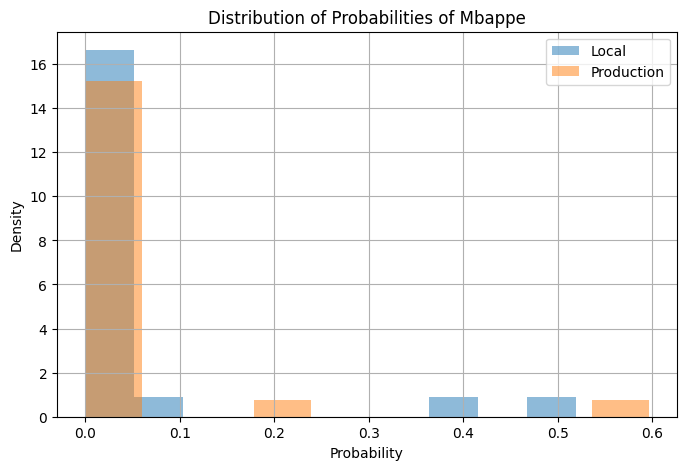

In [45]:
import matplotlib.pyplot as plt

# Crear el gráfico de distribución de probabilidades
plt.figure(figsize=(8, 5))
plt.hist(df_local_mbappe['probability'], bins=10, alpha=0.5, label='Local', density=True)
plt.hist(df_prod_mbappe['probability'], bins=10, alpha=0.5, label='Production', density=True)

plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Distribution of Probabilities of Mbappe')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [46]:
df_mbappe = df_local_mbappe.merge(df_prod_mbappe, on=['oid', 'class_name'], suffixes=('_local', '_prod'))
df_mbappe

,oid,class_name,probability_local,ranking_local,classifier_name,classifier_version,probability_prod,ranking_prod
0,ZTF18acbvugo,CEP,6.515733e-03,6,LC_classifier_ATAT_forced_phot,0.3.6,1.734872e-02,7
1,ZTF18acbvugo,AGN,5.488875e-06,12,LC_classifier_ATAT_forced_phot,0.3.6,1.189003e-05,14
2,ZTF18acbvugo,LPV,7.720343e-05,8,LC_classifier_ATAT_forced_phot,0.3.6,6.487266e-05,12
3,ZTF18acbvugo,SNIa,7.798994e-08,17,LC_classifier_ATAT_forced_phot,0.3.6,5.504101e-07,16
4,ZTF18acbvugo,EB/EW,3.661930e-01,2,LC_classifier_ATAT_forced_phot,0.3.6,5.961664e-01,1
5,ZTF18acbvugo,CV/Nova,3.991480e-03,7,LC_classifier_ATAT_forced_phot,0.3.6,3.706053e-02,6
6,ZTF18acbvugo,EA,5.190703e-01,1,LC_classifier_ATAT_forced_phot,0.3.6,5.277250e-02,4
7,ZTF18acbvugo,QSO,3.736879e-07,15,LC_classifier_ATAT_forced_phot,0.3.6,2.053501e-05,13
8,ZTF18acbvugo,YSO,6.102506e-02,3,LC_classifier_ATAT_forced_phot,0.3.6,5.662546e-02,3
9,ZTF18acbvugo,SNII,3.296341e-09,20,LC_classifier_ATAT_forced_phot,0.3.6,2.246547e-07,17


In [47]:
class_order = [
    "SNIa", "SNIbc", "SNIIb", "SNII", "SNIIn", "SLSN", 
    "TDE", "Microlensing", "QSO", "AGN", "Blazar", 
    "YSO", "CV/Nova", "LPV", "EA", "EB/EW", 
    "Periodic-Other", "RSCVn", "CEP", "RRLab", "RRLc", "DSCT"
]

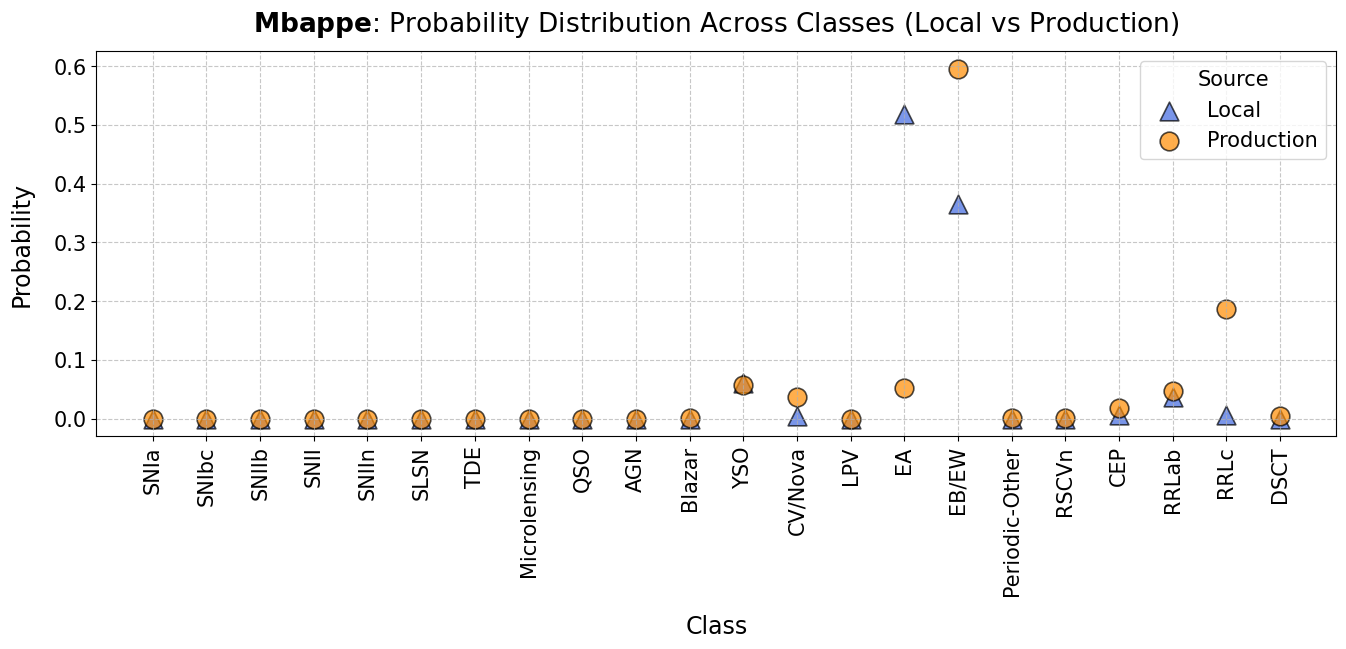

In [48]:
import matplotlib.pyplot as plt
import numpy as np

fs = 15

# Definir el orden deseado de las clases
class_order = [
    "SNIa", "SNIbc", "SNIIb", "SNII", "SNIIn", "SLSN", 
    "TDE", "Microlensing", "QSO", "AGN", "Blazar", 
    "YSO", "CV/Nova", "LPV", "EA", "EB/EW", 
    "Periodic-Other", "RSCVn", "CEP", "RRLab", "RRLc", "DSCT"
]

# Definir colores y estilos para Local y Producción
color_local = "royalblue"
color_prod = "darkorange"

# Crear la figura y los ejes con estilo mejorado
fig, ax = plt.subplots(figsize=(16, 5))

# Asignar coordenadas numéricas basadas en el orden deseado
class_to_x = {cls: i for i, cls in enumerate(class_order)}
df_mbappe = df_mbappe[df_mbappe['class_name'].isin(class_order)]  # Filtrar solo las clases en class_order
df_mbappe['class_x'] = df_mbappe['class_name'].map(class_to_x)

# Local (triángulo azul)
ax.scatter(
    df_mbappe['class_x'],
    df_mbappe['probability_local'],
    color=color_local,
    marker="^",
    s=180,  # Tamaño más grande para mejor visualización
    label="Local",
    edgecolors="black",  # Borde para mejor contraste
    linewidths=1.2,
    alpha=0.7  # Transparencia para mejorar la visualización
)

# Producción (círculo naranja)
ax.scatter(
    df_mbappe['class_x'],
    df_mbappe['probability_prod'],
    color=color_prod,
    marker="o",
    s=180,
    label="Production",
    edgecolors="black",
    linewidths=1.2,
    alpha=0.7  # Transparencia para mejorar la visualización
)

# Personalizar etiquetas y diseño
ax.set_xticks(np.arange(len(class_order)))
ax.set_xticklabels(class_order, rotation=90, fontsize=fs)
ax.tick_params(axis='y', labelsize=fs)

ax.set_xlabel('Class', fontsize=fs+2, labelpad=14)
ax.set_ylabel('Probability', fontsize=fs+2, labelpad=14)
title_text = r"$\bf{Mbappe}$: Probability Distribution Across Classes (Local vs Production)"
ax.set_title(title_text, fontsize=fs+4, pad=14, color='black')
ax.legend(fontsize=fs, loc='upper right', title="Source", title_fontsize=fs)
ax.grid(True, linestyle="--", alpha=0.7)

# Mostrar el gráfico con un estilo más limpio
plt.show()

In [49]:
from alerce_classifiers.squidward.model import (
    SquidwardFeaturesClassifier,
    SquidwardMapper,
)

SQUIDWARD_MODEL = "https://alerce-models.s3.amazonaws.com/squidward/1.1.5/hierarchical_random_forest_model.pkl"

model = SquidwardFeaturesClassifier(
    model_path=SQUIDWARD_MODEL,
    mapper=SquidwardMapper(),
)

predictions = model.predict(input_dto)
df_local_hbrf = predictions.probabilities
df_local_hbrf = df_local_hbrf.reset_index()
df_local_hbrf = df_local_hbrf.melt(id_vars=['oid'], var_name='class_name', value_name='probability')
df_local_hbrf['ranking'] = df_local_hbrf.groupby('oid')['probability'].rank(method="first", ascending=False).astype(int)
df_local_hbrf


,oid,class_name,probability,ranking
0,ZTF18acbvugo,AGN,0.005177,18
1,ZTF18acbvugo,Blazar,0.006448,16
2,ZTF18acbvugo,CEP,0.072485,7
3,ZTF18acbvugo,CV/Nova,0.107185,3
4,ZTF18acbvugo,DSCT,0.068813,8
5,ZTF18acbvugo,EA,0.088517,5
6,ZTF18acbvugo,EB/EW,0.096726,4
7,ZTF18acbvugo,LPV,0.012854,12
8,ZTF18acbvugo,Microlensing,0.024022,11
9,ZTF18acbvugo,Periodic-Other,0.148079,1


In [50]:
query_to_prod_hbrf = f"""
            SELECT * FROM probability as p
            WHERE oid  in ({','.join(oids)})
                    and p.classifier_name = 'LC_classifier_BHRF_forced_phot' 
                    and classifier_version = '1.1.4';
        """

df_prod_hbrf = pd.read_sql_query(query_to_prod_hbrf, con=engine)[df_local_hbrf.columns]
df_prod_hbrf

,oid,class_name,probability,ranking
0,ZTF18acbvugo,AGN,0.008365,19
1,ZTF18acbvugo,Blazar,0.009304,17
2,ZTF18acbvugo,CEP,0.075052,6
3,ZTF18acbvugo,CV/Nova,0.118908,3
4,ZTF18acbvugo,DSCT,0.054700,10
5,ZTF18acbvugo,EA,0.085315,4
6,ZTF18acbvugo,EB/EW,0.073638,7
7,ZTF18acbvugo,LPV,0.013141,12
8,ZTF18acbvugo,Microlensing,0.019045,11
9,ZTF18acbvugo,Periodic-Other,0.136159,2


In [51]:
df_hbrf = df_local_hbrf.merge(df_prod_hbrf, on=['oid', 'class_name'], suffixes=('_local', '_prod'))
df_hbrf

,oid,class_name,probability_local,ranking_local,probability_prod,ranking_prod
0,ZTF18acbvugo,AGN,0.005177,18,0.008365,19
1,ZTF18acbvugo,Blazar,0.006448,16,0.009304,17
2,ZTF18acbvugo,CEP,0.072485,7,0.075052,6
3,ZTF18acbvugo,CV/Nova,0.107185,3,0.118908,3
4,ZTF18acbvugo,DSCT,0.068813,8,0.054700,10
5,ZTF18acbvugo,EA,0.088517,5,0.085315,4
6,ZTF18acbvugo,EB/EW,0.096726,4,0.073638,7
7,ZTF18acbvugo,LPV,0.012854,12,0.013141,12
8,ZTF18acbvugo,Microlensing,0.024022,11,0.019045,11
9,ZTF18acbvugo,Periodic-Other,0.148079,1,0.136159,2


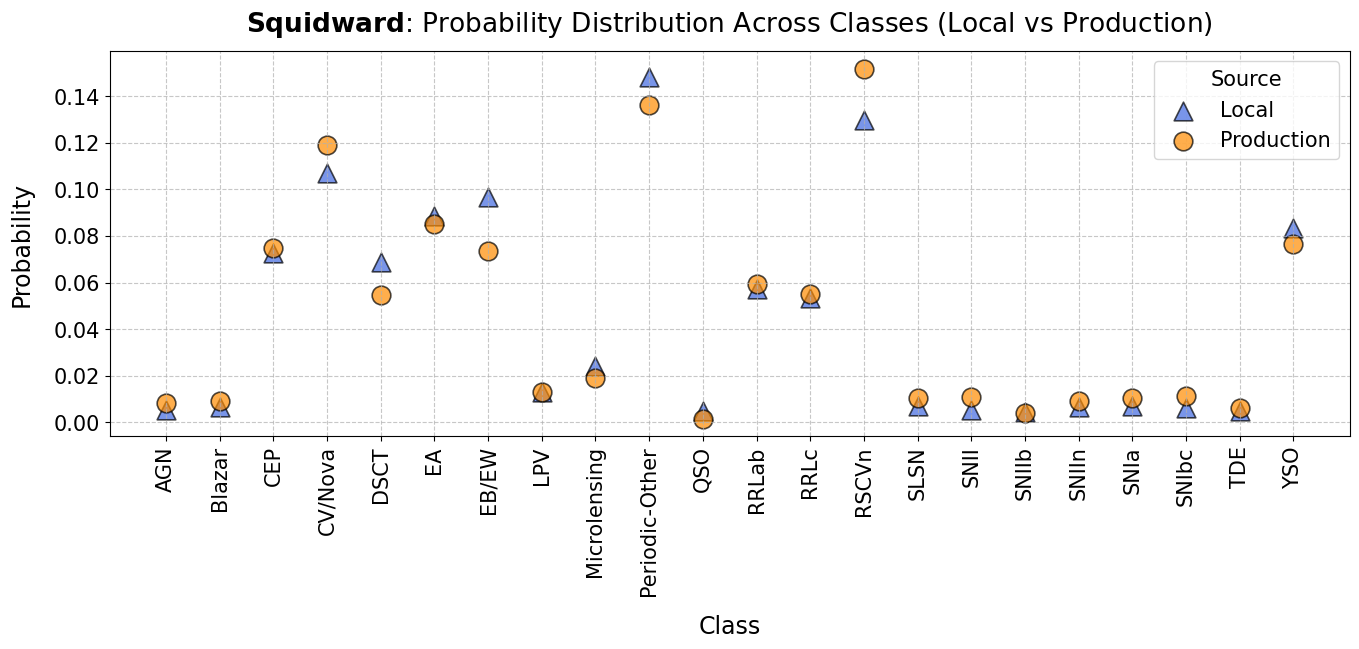

In [52]:
import matplotlib.pyplot as plt
import numpy as np

fs = 15

# Definir colores y estilos para Local y Producción
color_local = "royalblue"
color_prod = "darkorange"

# Crear la figura y los ejes con estilo mejorado
fig, ax = plt.subplots(figsize=(16, 5))

# Convertir las clases en valores numéricos para la visualización
class_labels = df_hbrf['class_name'].unique()
class_to_x = {cls: i for i, cls in enumerate(class_labels)}
df_hbrf['class_x'] = df_hbrf['class_name'].map(class_to_x)

# Local (triángulo azul)
ax.scatter(
    df_hbrf['class_x'],
    df_hbrf['probability_local'],
    color=color_local,
    marker="^",
    s=180,  # Tamaño más grande para mejor visualización
    label="Local",
    edgecolors="black",  # Borde para mejor contraste
    linewidths=1.2,
    alpha=0.7  # Transparencia para mejorar la visualización
)

# Producción (círculo naranja)
ax.scatter(
    df_hbrf['class_x'],
    df_hbrf['probability_prod'],
    color=color_prod,
    marker="o",
    s=180,
    label="Production",
    edgecolors="black",
    linewidths=1.2,
    alpha=0.7  # Transparencia para mejorar la visualización
)

# Personalizar etiquetas y diseño
ax.set_xticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels, rotation=90, fontsize=fs)
ax.tick_params(axis='y', labelsize=fs)

ax.set_xlabel('Class', fontsize=fs+2, labelpad=14)
ax.set_ylabel('Probability', fontsize=fs+2, labelpad=14)
title_text = r"$\bf{Squidward}$: Probability Distribution Across Classes (Local vs Production)"
ax.set_title(title_text, fontsize=fs+4, pad=14, color='black')
ax.legend(fontsize=fs, loc='upper right', title="Source", title_fontsize=fs)
ax.grid(True, linestyle="--", alpha=0.7)

# Mostrar el gráfico con un estilo más limpio
plt.show()


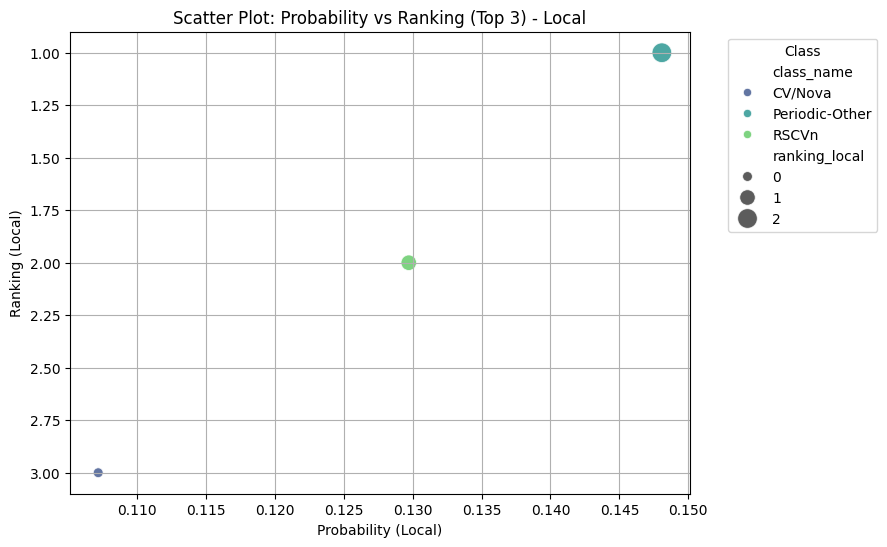

In [313]:
df_top3 = df_hbrf[(df_hbrf['ranking_local'] <= 3) | (df_hbrf['ranking_prod'] <= 3)]

# 1️⃣ Scatter Plot: Probabilidad vs Ranking (solo top 3)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_top3['probability_local'],
    y=df_top3['ranking_local'],
    hue=df_top3['class_name'],
    size=3 - df_top3['ranking_local'],  # Tamaño más grande para rank 1
    sizes=(50, 200),
    palette='viridis',
    alpha=0.8
)
plt.gca().invert_yaxis()  # Ranking 1 debe estar arriba
plt.xlabel('Probability (Local)')
plt.ylabel('Ranking (Local)')
plt.title('Scatter Plot: Probability vs Ranking (Top 3) - Local')
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

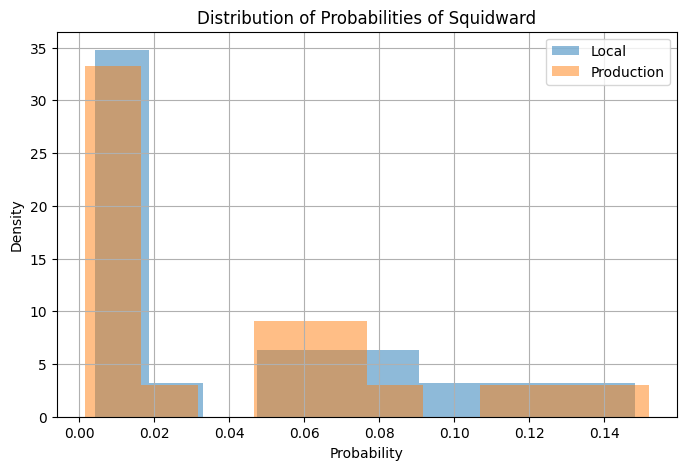

In [299]:
import matplotlib.pyplot as plt

# Crear el gráfico de distribución de probabilidades
plt.figure(figsize=(8, 5))
plt.hist(df_local_hbrf['probability'], bins=10, alpha=0.5, label='Local', density=True)
plt.hist(df_prod_hbrf['probability'], bins=10, alpha=0.5, label='Production', density=True)

plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Distribution of Probabilities of Squidward')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

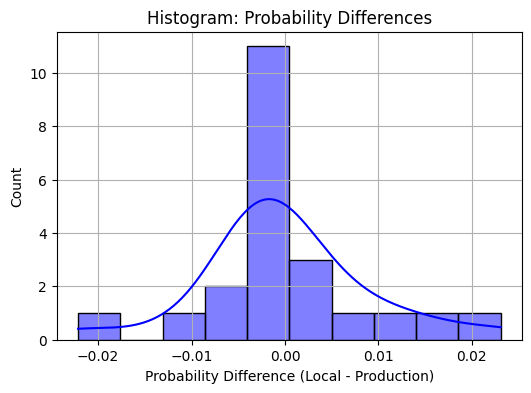

In [304]:
import seaborn as sns

# Calcular diferencia de probabilidades
df_hbrf['probability_diff'] = df_hbrf['probability_local'] - df_hbrf['probability_prod']

# 1️⃣ Histograma de Diferencias en Probabilidad
plt.figure(figsize=(6, 4))
sns.histplot(df_hbrf['probability_diff'], bins=10, kde=True, color='b')
plt.xlabel('Probability Difference (Local - Production)')
plt.ylabel('Count')
plt.title('Histogram: Probability Differences')
plt.grid(True)
plt.show()

/tmp/ipykernel_2365004/1155790633.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_hbrf['class_name'], y=df_hbrf['probability_diff'], palette='viridis')


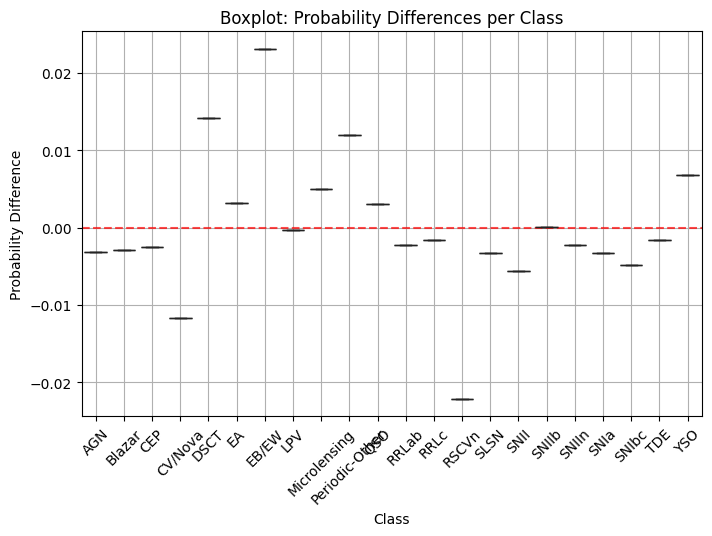

In [307]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_hbrf['class_name'], y=df_hbrf['probability_diff'], palette='viridis')
plt.axhline(0, linestyle='--', color='r', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Probability Difference')
plt.title('Boxplot: Probability Differences per Class')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

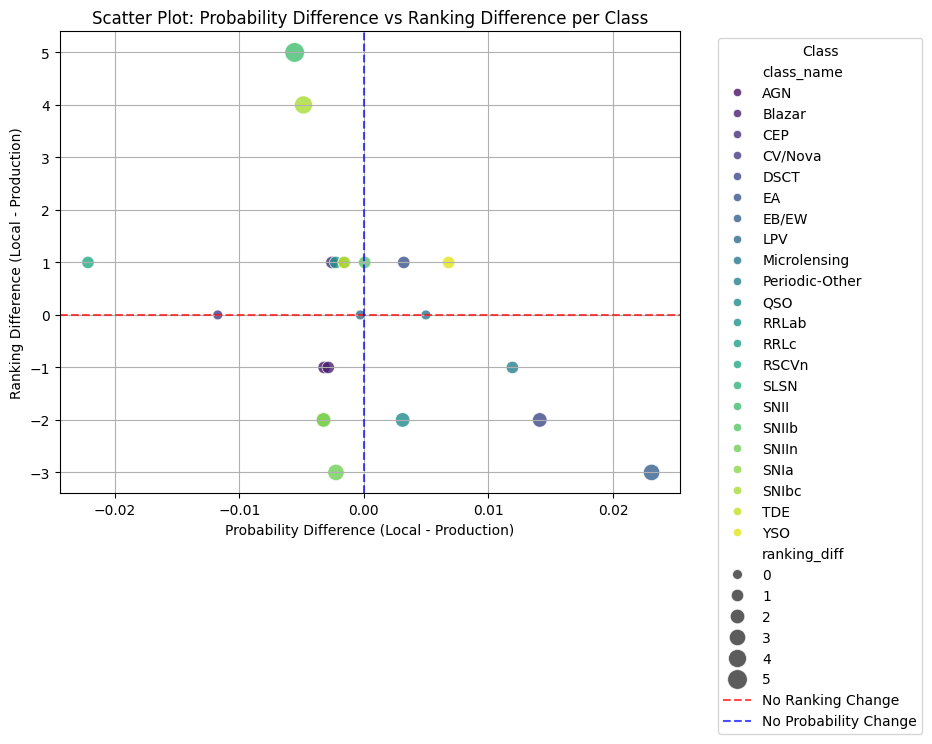

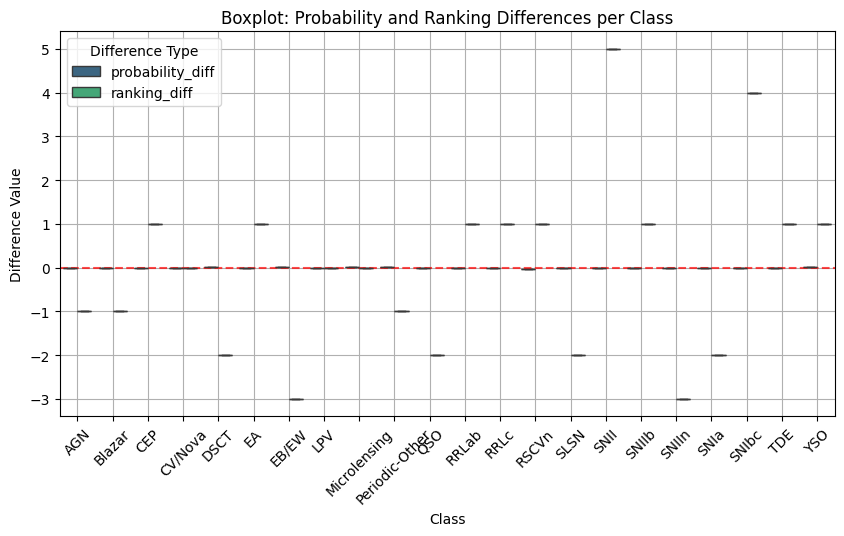

In [310]:
df_hbrf['ranking_diff'] = df_hbrf['ranking_local'] - df_hbrf['ranking_prod']
df_hbrf['probability_diff'] = df_hbrf['probability_local'] - df_hbrf['probability_prod']

# 1️⃣ Scatter Plot: Diferencia en Probabilidad vs Diferencia en Ranking por Clase
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_hbrf['probability_diff'],
    y=df_hbrf['ranking_diff'],
    hue=df_hbrf['class_name'],
    size=abs(df_hbrf['ranking_diff']),  # Tamaño según la magnitud del cambio en ranking
    sizes=(50, 200),
    palette='viridis',
    alpha=0.8
)
plt.axhline(0, linestyle='--', color='r', alpha=0.7, label='No Ranking Change')
plt.axvline(0, linestyle='--', color='b', alpha=0.7, label='No Probability Change')
plt.xlabel('Probability Difference (Local - Production)')
plt.ylabel('Ranking Difference (Local - Production)')
plt.title('Scatter Plot: Probability Difference vs Ranking Difference per Class')
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# 2️⃣ Boxplot: Diferencia en Probabilidad y Ranking por Clase
plt.figure(figsize=(10, 5))
df_melted = df_hbrf.melt(id_vars=['class_name'], value_vars=['probability_diff', 'ranking_diff'], var_name='Difference Type', value_name='Value')
sns.boxplot(x='class_name', y='Value', hue='Difference Type', data=df_melted, palette='viridis')
plt.axhline(0, linestyle='--', color='r', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Difference Value')
plt.title('Boxplot: Probability and Ranking Differences per Class')
plt.xticks(rotation=45)
plt.legend(title="Difference Type")
plt.grid(True)
plt.show()

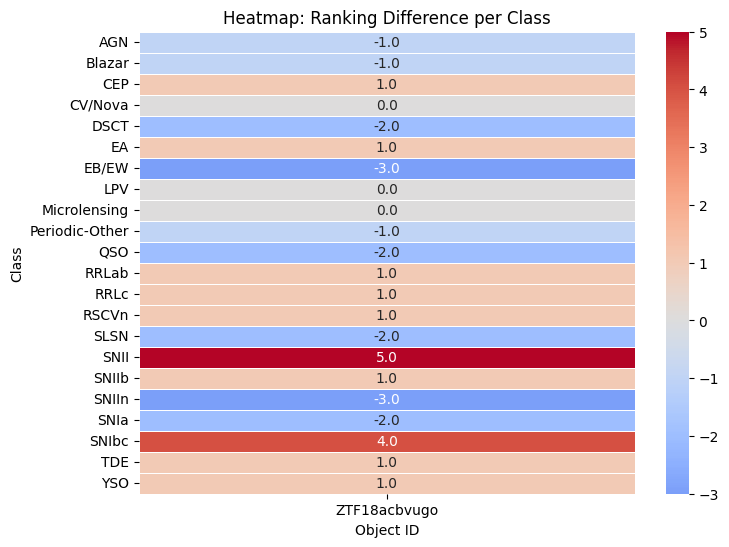

In [311]:
# 3️⃣ Heatmap de Cambio de Ranking por Clase
heatmap_data = pd.pivot_table(df_hbrf, values='ranking_diff', index='class_name', columns='oid', aggfunc='mean').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5, center=0)
plt.xlabel('Object ID')
plt.ylabel('Class')
plt.title('Heatmap: Ranking Difference per Class')
plt.show()

In [ ]:
from lc_classifier.utils import create_astro_object

ao = create_astro_object(
    data_origin='database',
    detections=detections,
    forced_photometry=forced_photometry,
    xmatch=None,
    reference=None,
    non_detections=None,
)

In [14]:
#oids = ["ZTF18aabgipf", "ZTF18aavtats"]
oids = ['ZTF20aclvqmx']
oids = [f"'{oid}'" for oid in oids]
#oids_str = ", ".join(f"'{oid}'" for oid in oids) 

In [15]:
query_detections = f"""
    SELECT * FROM detection
    WHERE oid IN ({','.join(oids)}) and rb >= 0.55;
"""

detections = pd.read_sql_query(query_detections, con=engine)
detections

,oid,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,...,sigmagapbig,rfid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious,parent_candid,has_stamp,step_id_corr
0,ZTF20aclvqmx,2716363714315015011,60470.363715,2,2716363714315,20.411406,1,2716,312.645362,11.953960,...,0.2394,5.431202e+08,18.124825,0.027930,0.031430,True,False,NaN,True,24.5.1
1,ZTF20aclvqmx,2718439834315015017,60472.439838,1,2718439834315,20.633200,1,2718,312.645267,11.953988,...,0.3947,NaN,19.084934,0.056601,0.058385,True,False,2.736391e+18,False,24.5.1
2,ZTF20aclvqmx,2722456904315015018,60476.456910,2,2722456904315,20.593800,1,2722,312.645356,11.954091,...,0.2158,NaN,18.108067,0.033905,0.036756,True,False,2.736391e+18,False,24.5.1
3,ZTF20aclvqmx,2725359274315015009,60479.359271,2,2725359274315,20.023352,1,2725,312.645291,11.954002,...,0.4066,5.431202e+08,18.116410,0.030457,0.033648,True,False,NaN,True,24.5.1
4,ZTF20aclvqmx,2736391454315015023,60490.391458,2,2736391454315,20.462019,1,2736,312.645366,11.954054,...,0.2747,5.431202e+08,18.122684,0.023093,0.027207,True,False,NaN,True,24.5.1
5,ZTF20aclvqmx,2740358994315015015,60494.358993,2,2740358994315,20.536700,1,2740,312.645397,11.954088,...,0.3566,NaN,18.141165,0.034247,0.037242,True,False,2.753358e+18,False,24.5.1
6,ZTF20aclvqmx,2753358264315015016,60507.358264,2,2753358264315,20.466166,1,2753,312.645331,11.954049,...,0.2636,5.431202e+08,18.113300,0.022522,0.026658,True,False,NaN,True,24.5.1
7,ZTF20aclvqmx,2784264004315025034,60538.264005,2,2784264004315,19.814900,1,2784,312.645415,11.954071,...,0.4117,NaN,18.080547,0.043095,0.045262,True,False,2.805232e+18,False,24.5.1
8,ZTF20aclvqmx,2795275934315015012,60549.275937,1,2795275934315,20.572600,1,2795,312.645396,11.954119,...,0.3597,NaN,19.037806,0.061131,0.062651,True,False,2.824193e+18,False,24.5.1
9,ZTF20aclvqmx,2803261404315015011,60557.261400,1,2803261404315,20.607700,1,2803,312.645469,11.954107,...,0.5656,NaN,19.028149,0.063716,0.065150,True,False,2.824193e+18,False,24.5.1


In [11]:
for col in detections.columns:
    print(col)

candid
oid
mjd
fid
pid
diffmaglim
isdiffpos
nid
ra
dec
magpsf
sigmapsf
magap
sigmagap
distnr
rb
rbversion
drb
drbversion
magapbig
sigmagapbig
rfid
magpsf_corr
sigmapsf_corr
sigmapsf_corr_ext
corrected
dubious
parent_candid
has_stamp
step_id_corr


In [12]:
# FORCED PHOTOMETRY
query_forced_photometry = f"""
                    SELECT * FROM forced_photometry
                    WHERE oid in ({','.join(oids)}) and procstatus in ('0', '57');
                    """

# and procstatus in ('0', '57') ;
# Por que aplica el filtro procstatus entre 0 y 57?
forced_photometry = pd.read_sql_query(query_forced_photometry, con=engine)
forced_photometry

,pid,oid,mjd,fid,ra,dec,e_ra,e_dec,mag,e_mag,...,diffmaglim,programid,procstatus,distnr,ranr,decnr,magnr,sigmagnr,chinr,sharpnr
0,2973560900615,ZTF20aclvqmx,60727.560903,2,312.645314,11.954185,None,None,19.77495,0.519044,...,18.2817,1,0,0.304448,312.645294,11.954106,18.334,0.019,0.477,0.02


In [48]:
for col in forced_photometry.columns:
    print(col)

pid
oid
mjd
fid
ra
dec
e_ra
e_dec
mag
e_mag
mag_corr
e_mag_corr
e_mag_corr_ext
isdiffpos
corrected
dubious
parent_candid
has_stamp
field
rcid
rfid
sciinpseeing
scibckgnd
scisigpix
magzpsci
magzpsciunc
magzpscirms
clrcoeff
clrcounc
exptime
adpctdif1
adpctdif2
diffmaglim
programid
procstatus
distnr
ranr
decnr
magnr
sigmagnr
chinr
sharpnr


In [49]:
lc_det_ff = pd.concat([detections, forced_photometry])
lc_det_ff

,oid,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,...,adpctdif1,adpctdif2,programid,procstatus,ranr,decnr,magnr,sigmagnr,chinr,sharpnr
0,ZTF20aclvqmx,2.716364e+18,60470.363715,2,2716363714315,20.411406,1,2716.0,312.645362,11.953960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ZTF20aclvqmx,2.718440e+18,60472.439838,1,2718439834315,20.633200,1,2718.0,312.645267,11.953988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ZTF20aclvqmx,2.722457e+18,60476.456910,2,2722456904315,20.593800,1,2722.0,312.645356,11.954091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ZTF20aclvqmx,2.725359e+18,60479.359271,2,2725359274315,20.023352,1,2725.0,312.645291,11.954002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ZTF20aclvqmx,2.736391e+18,60490.391458,2,2736391454315,20.462019,1,2736.0,312.645366,11.954054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,ZTF20aclvqmx,NaN,60534.252222,1,2780252224315,20.719299,1,NaN,312.645416,11.954047,...,0.053127,0.052644,1.0,0,312.645264,11.954123,19.333000,0.018,0.587,-0.009
104,ZTF20aclvqmx,NaN,60532.323287,2,2778323284315,20.914801,1,NaN,312.645416,11.954047,...,0.052043,0.058391,1.0,0,312.645264,11.954128,18.303999,0.017,0.504,0.023
105,ZTF20aclvqmx,NaN,60532.253276,1,2778253274315,20.866301,1,NaN,312.645416,11.954047,...,0.054988,0.054125,1.0,0,312.645264,11.954123,19.333000,0.018,0.587,-0.009
106,ZTF20aclvqmx,NaN,60531.331169,1,2777331164315,20.761600,1,NaN,312.645416,11.954047,...,0.059938,0.061376,1.0,0,312.645264,11.954123,19.333000,0.018,0.587,-0.009


In [50]:
lc_det_ff_with_drop = lc_det_ff.drop_duplicates(
    ["candid", "oid"], keep="first"
)
lc_det_ff_with_drop

,oid,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,...,adpctdif1,adpctdif2,programid,procstatus,ranr,decnr,magnr,sigmagnr,chinr,sharpnr
0,ZTF20aclvqmx,2.716364e+18,60470.363715,2,2716363714315,20.411406,1,2716.0,312.645362,11.953960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ZTF20aclvqmx,2.718440e+18,60472.439838,1,2718439834315,20.633200,1,2718.0,312.645267,11.953988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ZTF20aclvqmx,2.722457e+18,60476.456910,2,2722456904315,20.593800,1,2722.0,312.645356,11.954091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ZTF20aclvqmx,2.725359e+18,60479.359271,2,2725359274315,20.023352,1,2725.0,312.645291,11.954002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ZTF20aclvqmx,2.736391e+18,60490.391458,2,2736391454315,20.462019,1,2736.0,312.645366,11.954054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ZTF20aclvqmx,2.740359e+18,60494.358993,2,2740358994315,20.536700,1,2740.0,312.645397,11.954088,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ZTF20aclvqmx,2.753358e+18,60507.358264,2,2753358264315,20.466166,1,2753.0,312.645331,11.954049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ZTF20aclvqmx,2.784264e+18,60538.264005,2,2784264004315,19.814900,1,2784.0,312.645415,11.954071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ZTF20aclvqmx,2.795276e+18,60549.275937,1,2795275934315,20.572600,1,2795.0,312.645396,11.954119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ZTF20aclvqmx,2.803261e+18,60557.261400,1,2803261404315,20.607700,1,2803.0,312.645469,11.954107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Compute Features

In [54]:
def patch_wise(oid_list):
    columns = ["oid", "w1mpro", "w2mpro", "w3mpro", "w4mpro"]
    df = pd.DataFrame({"oid": oid_list})  # Fill only the oid column
    for col in columns[1:]:  # Add empty columns for the rest
        df[col] = None
    return df

def features_from_db(features: pd.DataFrame):
    def normalize_name(x: str | int):
        if "_0" in x:
            return x[:-2].replace("/", "_")
        return x.replace("/", "_")

    def normalize_fid(x):
        if x == 0:
            return None
        if x == 1:
            return "g"
        if x == 2:
            return "r"
        if x == 12:
            return "g,r"

    # features['name'] = features['name'] + '_' + features['fid'].astype(str)
    if len(features) >= 1:
        features["name"] = features.apply(lambda x: normalize_name(x["name"]), axis=1)
        features["fid"] = features.apply(lambda x: normalize_fid(x["fid"]), axis=1)
        return features
    else:
        return None

In [1]:
# GET FEATURES
query_features = f"""
                    SELECT * FROM feature as f 
                    WHERE f.oid in ({','.join(oids)}) and f.version = '27.3.0';
                    """

features = pd.read_sql_query(query_features, con=engine)
features

NameError: name 'oids' is not defined

In [56]:
features = features_from_db(features)
features

,oid,name,value,fid,version
0,ZTF20aclvqmx,Amplitude,NaN,g,27.4.0
1,ZTF20aclvqmx,Amplitude,0.055532,r,27.4.0
2,ZTF20aclvqmx,AndersonDarling,NaN,g,27.4.0
3,ZTF20aclvqmx,AndersonDarling,0.999087,r,27.4.0
4,ZTF20aclvqmx,Autocor_length,NaN,g,27.4.0
...,...,...,...,...,...
204,ZTF20aclvqmx,ulens_u0,0.140078,g,27.4.0
205,ZTF20aclvqmx,ulens_u0,0.000853,r,27.4.0
206,ZTF20aclvqmx,W1-W2,NaN,None,27.4.0
207,ZTF20aclvqmx,W2-W3,NaN,None,27.4.0


In [58]:
from lc_classifier.utils import (
    #all_features_from_astro_objects,
    create_astro_object,
    #EmptyLightcurveException,
)

ImportError: Numba needs NumPy 1.26 or less

In [ ]:
ao = create_astro_object(
    data_origin='database',
    detections=detections,
    forced_photometry=forced_photometry,
    xmatch=None,
    reference=None,
    non_detections=None,
)

ao

In [ ]:
from lc_classifier.features.preprocess.ztf import (
    ZTFLightcurvePreprocessor,
)
from lc_classifier.features.composites.ztf import ZTFFeatureExtractor

lightcurve_preprocessor = ZTFLightcurvePreprocessor(drop_bogus=False)
lightcurve_preprocessor.preprocess_batch(batch_astro_objects)

In [ ]:
def dataframes_to_astro_object_list(
    detections,
    forced_photometry,
    xmatch,
    reference,
    features=None,
    data_origin="database",
    verbose=True,
):
    oids = detections["oid"].unique()
    detections.set_index("oid", inplace=True)
    detections.sort_index(inplace=True)
    forced_photometry_columns = forced_photometry.columns
    forced_photometry.set_index("oid", inplace=True)
    forced_photometry.sort_index(inplace=True)
    xmatch.set_index("oid", inplace=True)
    reference_columns = reference.columns
    reference.set_index("oid", inplace=True)
    astro_objects_list = []
    for oid in oids:
        try:
            xmatch_oid = xmatch.loc[[oid]].reset_index()
        except:
            logging.warning("xmatch metadata patched!")
            xmatch_oid = patch_xmatch_by_oid(oid=oid).reset_index()

        assert len(xmatch_oid) == 1
        xmatch_oid = xmatch_oid.iloc[0]
        if oid in forced_photometry.index:
            forced_photometry_oid = forced_photometry.loc[[oid]].reset_index()
        else:
            forced_photometry_oid = pd.DataFrame(columns=forced_photometry_columns)
        if oid in reference.index:
            reference_oid = reference.loc[[oid]].reset_index()
        else:
            reference_oid = pd.DataFrame(columns=reference_columns)
        try:
            ao = create_astro_object(
                data_origin=data_origin,
                detections=detections.loc[[oid]].reset_index(),
                forced_photometry=forced_photometry_oid,
                xmatch=xmatch_oid,
                reference=reference_oid,
                non_detections=None,
            )
            if features is not None:
                """add features from db"""
                try:
                    ao.features = features.loc[features.oid == oid][
                        ["name", "value", "fid", "version"]
                    ]
                except:
                    ao.features = None
        except EmptyLightcurveException:
            continue

        astro_objects_list.append(ao)
    return astro_objects_list

In [ ]:
engine = sa.create_engine(
    f"postgresql+psycopg2://{params['user']}:{params['password']}@{params['host']}/{params['dbname']}"
)
engine.begin()


""" QUERIES """
# DETECTION
query_detections = f"""
                    SELECT * FROM detection
                    WHERE oid in ({oids_str}) and rb >= 0.55;
                    """
detections = pd.read_sql_query(query_detections, con=engine)

# FORCED PHOTOMETRY
query_forced_photometry = f"""
                    SELECT * FROM forced_photometry
                    WHERE oid in ({oids_str}) and procstatus in ('0', '57');
                    """
forced_photometry = pd.read_sql_query(query_forced_photometry, con=engine)

# REFERENCE
query_reference = f"""
                    SELECT oid, rfid, sharpnr, chinr FROM reference
                    WHERE oid in ({oids_str}) and chinr >= 0;
                    """
reference = pd.read_sql_query(query_reference, con=engine)
reference = reference.drop_duplicates("rfid")

# XMATCH
query_xmatch = f"""
                SELECT oid, oid_catalog, dist FROM xmatch
                WHERE oid in ({oids_str}) and catid='allwise';
                """
xmatch = pd.read_sql_query(query_xmatch, con=engine)
xmatch = xmatch.sort_values("dist").drop_duplicates("oid")
oid_catalog = [f"'{oid}'" for oid in xmatch["oid_catalog"].values]

# ALL WISE
query_wise = f"""
            SELECT oid_catalog, w1mpro, w2mpro, w3mpro, w4mpro FROM allwise
            WHERE oid_catalog in ({','.join(oid_catalog)});
            """
try:
    wise = pd.read_sql_query(query_wise, con=engine).set_index("oid_catalog")
    wise = pd.merge(xmatch, wise, on="oid_catalog", how="outer")
    wise = wise[["oid", "w1mpro", "w2mpro", "w3mpro", "w4mpro"]].set_index("oid")
except:
    wise = patch_wise(oids)
    logging.warning("wise patched")

# PANSTARR
query_ps = f"""
            SELECT oid, sgscore1, sgmag1, srmag1, simag1, szmag1, distpsnr1 FROM ps1_ztf
            WHERE oid in ({oids_str});
            """
ps = pd.read_sql_query(query_ps, con=engine)
ps = ps.drop_duplicates("oid").set_index("oid")

#
xmatch = pd.concat([wise, ps], axis=1).reset_index()

# GET FEATURES
query_features = f"""
                    SELECT  * FROM feature as f 
                    WHERE f.oid  in ({oids_str}) and f.version = '27.3.0';
                    """
features = pd.read_sql_query(query_features, con=engine)
features = features_from_db(features)

# CREATE ASTRO OBJECTS FROM DATAFRAMES EXTRATED FROM DATABASE
output = dataframes_to_astro_object_list(
    detections=detections,
    forced_photometry=forced_photometry,
    xmatch=xmatch,
    reference=reference,
    features=features,
)

In [ ]:
from lc_classifier.features.preprocess.ztf import ZTFLightcurvePreprocessor
from lc_classifier.features.composites.ztf import ZTFFeatureExtractor
from lc_classifier.features.core.base import astro_object_from_dict

In [ ]:
lightcurve_preprocessor = ZTFLightcurvePreprocessor(drop_bogus=False)
lightcurve_preprocessor.preprocess_batch(batch_astro_objects)
feature_extractor = ZTFFeatureExtractor()
feature_extractor.compute_features_batch(batch_astro_objects, progress_bar=False)

In [17]:
# GET FEATURES
query_features = f"""
                    SELECT  * FROM feature as f 
                    WHERE f.oid  in ({oids_str}) and f.version = '27.4.0';
                    """

features = pd.read_sql_query(query_features, con=engine)
features

ProgrammingError: (psycopg2.errors.SyntaxError) syntax error at or near "ZTF18aabgipf"
LINE 3:                     WHERE f.oid  in (''ZTF18aabgipf'', ''ZTF...
                                               ^

[SQL: 
                    SELECT  * FROM feature as f 
                    WHERE f.oid  in (''ZTF18aabgipf'', ''ZTF18aavtats'') and f.version = '27.4.0';
                    ]
(Background on this error at: https://sqlalche.me/e/20/f405)

In [9]:
RANKING = 1

query_to_prod_bhrf = f"""
                SELECT  * FROM alerce.probability as p
                WHERE oid  in ({oids_str})
                        and p.classifier_name = 'LC_classifier_BHRF_forced_phot(beta)' 
                        and p.ranking = {RANKING} 
                        and classifier_version = '1.1.5';
            """

query_to_prod_atat = f"""
                SELECT  * FROM alerce.probability as p
                WHERE oid  in ({oids_str})
                        and p.classifier_name = 'LC_classifier_ATAT_forced_phot(beta)' 
                        and p.ranking = {RANKING} 
                        and classifier_version = '0.3.6';
            """

engine = sa.create_engine('postgresql+psycopg2://' + params['user'] \
                          + ':' + params['password'] + '@' + params['host'] \
                          + '/' + params['dbname'])
engine.begin()

prod_probs_df_bhrf = pd.read_sql_query(query_to_prod_bhrf, con=engine)
prod_probs_df_atat = pd.read_sql_query(query_to_prod_atat, con=engine)

In [10]:
prod_probs_df_atat

,oid,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF18aabgipf,LC_classifier_ATAT_forced_phot(beta),0.3.6,LPV,0.893018,1


In [11]:
prod_probs_df_bhrf

,oid,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF18aabgipf,LC_classifier_BHRF_forced_phot(beta),1.1.5,LPV,0.689308,1


In [ ]:
a = ['ZTF17aaaafww',
 'ZTF17aaaagbs',
 'ZTF17aaaagvz',
 'ZTF17aaaagwz',
 'ZTF17aaaaotk',
 'ZTF17aaabate',
 'ZTF17aaabdxt',
 'ZTF17aaabebp',
 'ZTF17aaabebt',
 'ZTF17aaabwrg',
 'ZTF17aaacnht',
 'ZTF17aaaewdz',
 'ZTF17aaagezb',
 'ZTF17aaagtow',
 'ZTF17aaagypl',
 'ZTF17aaahegx',
 'ZTF17aaahejg',
 'ZTF17aaahere',
 'ZTF17aaahixx',
 'ZTF17aaahtvd',
 'ZTF17aaaiedz',
 'ZTF17aaaiegd',
 'ZTF17aaaignl',
 'ZTF17aaaihls',
 'ZTF17aaaihlz']


# Esos no dan iguales
b = ['ZTF17aaaewpk',
 'ZTF17aabrocy',
 'ZTF18aaaatqy',
 'ZTF18aaabter',
 'ZTF18aaakkxx',
 'ZTF18ablmuyz',
 'ZTF18absceqp',
 'ZTF18abzrmcq']
 

In [5]:
environment_variables = {
    "POSTGRES_USER": "postgres",
    "POSTGRES_PASSWORD": "postgres",
    "POSTGRES_DB": "ztf",
    "POSTGRES_PORT": 5432,
    "POSTGRES_HOST": "localhost",
    "POSTGRES_SCHEMA": "alerce",
    "N_JOBS": 16,
    "CONTAINER_NAME": "psql_docker",
    "CONTAINER_VOLUME_NAME": "integration_psql_data",
    "ASTRO_OBJECTS_PATH": "./batch/data",
    "ASTRO_OBJECTS_PATH_OUTPUT": "./batch/output",
}

In [15]:
import psycopg2

In [20]:
environment_variables = {
    "USER":"alerce",
    "PASSWORD":"IG,eFKHi5[",
    "HOST":"30.0.85.190",
    "PORT":"5432",
    "DB_NAME":"ztf"
    }

In [18]:
conn = psycopg2.connect(
    host=environment_variables['HOST'],
    port=environment_variables['PORT'],
    user=environment_variables['USER'],
    password=environment_variables['PASSWORD'],
    database=environment_variables['DB_NAME']
)

#lightcurves = pd.read_sql(query, conn)

OperationalError: connection to server at "30.0.85.190", port 5432 failed: Connection timed out
	Is the server running on that host and accepting TCP/IP connections?


In [ ]:
# Lista de OIDs y ranking
oids = ['ZTF17aaaiedz'] #, 'oid2', 'oid3']  # Reemplaza con tus OIDs
RANKING = 1  # Ajusta según sea necesario

# Consulta segura con parámetros
query = """
    SELECT * FROM alerce.probability
    WHERE oid IN %(oids)s
    AND classifier_name = 'LC_classifier_ATAT_forced_phot(beta)' 
    AND ranking = %(ranking)s
    AND classifier_version = '0.3.4';
"""

# Ejecutar la consulta con parámetros
local_probs_df_atat = pd.read_sql(query, conn, params={'oids': tuple(oids), 'ranking': RANKING})

# Cerrar la conexión
conn.close()

In [ ]:
local_engine = sa.create_engine(
    f"postgresql+psycopg2://{environment_variables['POSTGRES_USER']}:{environment_variables['POSTGRES_PASSWORD']}@{environment_variables['POSTGRES_HOST']}/{environment_variables['POSTGRES_DB']}"
)

# Definir valores de detección
ndet_max = 50
ndet_min = 8

In [13]:
## Consulta SQL con parámetros seguros
#query = """
#    SELECT * FROM alerce.probability
#    WHERE classifier_name = 'LC_classifier_ATAT_forced_phot(beta)' 
#    AND ranking <= 3 
#    AND ndet BETWEEN %(ndet_min)s AND %(ndet_max)s
#"""

## Ejecutar la consulta con parámetros
#local_probs_df_atat = pd.read_sql(query, conn, params={'ndet_min': ndet_min, 'ndet_max': ndet_max})


OperationalError: (psycopg2.OperationalError) connection to server at "localhost" (127.0.0.1), port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [ ]:
ndet_max = 50
ndet_min = 8

query_to_local_atat = f"""
                SELECT * from alerce.probability as p
                        WHERE p.classifier_name  = 'LC_classifier_ATAT_forced_phot(beta)' 
                            and p.ranking <=3 and ndet <= {ndet_max} and ndet >= {ndet_min} 
                """

#local_probs_df_bhrf = pd.read_sql_query(query_to_local_bhrf, con=local_engine)
local_probs_df_atat = pd.read_sql_query(query_to_local_atat, con=local_engine)